<a href="https://colab.research.google.com/github/lssds2024/lssds2024/blob/main/ManifoldLearning/Convolutional_aenc_faces_tocomplete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

last modified

author FBB for LSDSS2024

# Autoencoder notebook
create superresolution headshots from low resolution  versions in (black and white):
- load a set of images
- lower the resolution to build the input data
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the original (heigher resolution) images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

THE DATA PREPARATION IS DONE IN THE NOTEBOOK BUT CAN BE SKIPPED: GET THE DATA SAVED AS faces_saved.npy and go to point 1B

DATA AVAILABLE AT https://drive.google.com/file/d/1-4iJBCkXN3EWDrubCjicpZoTosJDS4ah/view?usp=drive_link
or https://bit.ly/faces95


In [ ]:
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import Input, Model
from keras import backend as K
from keras.callbacks import EarlyStopping


In [ ]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm.notebook import tqdm

# not needed on colab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def compareinout_flat(i, outim, X_tr):
  '''utility function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131)
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  ax.imshow(outim[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133)
  ax.imshow(y_te[i].reshape(imgs[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

# 1A load head shots from known training data from a shared drive if you have access to it

 skip to 1B to load images already read in and turned into a numpy array which you can find in the github repo



In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/Shareddrives/LSDSS24/

/content/gdrive/Shareddrives/LSDSS24


In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
#!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [ ]:
#!unzip faces95.zip

In [ ]:
!ls

In [ ]:
flist = glob.glob("faces95/*/*jpg")

In [ ]:
N = len(flist)
N

1140


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

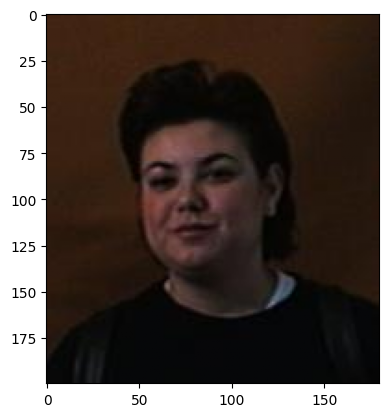

In [ ]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2, 25:165:2, :1].shape, np.prod(np_im.shape[1:])

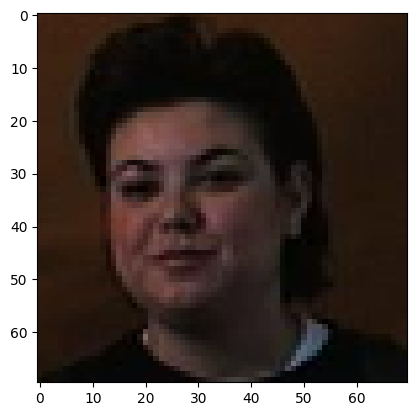

In [ ]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>. If you run this you should run this on CPUs, not GPUs, so you do not waste resources

In [ ]:
!mkdir data

## CROP, TURN TO B/W, AND SAVE

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 3))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255
  # here I collect the certain portion of each image
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2].astype(float) / 255
#uncomment this to save another array of images - I saved the original one as data/faces.npy


<ipython-input-39-fe193f33b121>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1140 [00:00<?, ?it/s]

In [ ]:
#imgs orig is the full resolution image, save a version with axes in powers of 2
imgs = imgs[:, :-6, :-6, :].mean(axis=3, keepdims=True)
np.save("data/faces_saved.npy", imgs)

In [ ]:
imgs.shape

(1140, 64, 64, 1)

# 1B you can read the images below if you have saved them earlier

first, download faces_save.npy and put it in a local folder called data

In [ ]:
imgs = np.load("data/faces_saved.npy")
imgs.shape

(1140, 64, 64, 1)

# 2 lower the resolution to build the training set

- sample every 4th pixel
- create a 75/25 train/test set with the command
          train_test_split(input, target, test_size = .25, random_state=1)
          What are the input and output data??



In [ ]:
# lower the resolution
...

(1140, 16, 16, 1)

In [ ]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape),

(256, 4096)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [ ]:
from sklearn.model_selection import train_test_split
...


In [ ]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1128, 16, 16, 1), (12, 16, 16, 1), (1128, 64, 64, 1), (12, 64, 64, 1))

# 3 build a feed forward autoencoder model

In [ ]:
#each image needs to be unravel into a flat array
X_tr_flat = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
X_te_flat = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
y_tr_flat = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
y_te_flat = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [ ]:
X_tr_flat.shape, X_te_flat.shape, y_tr_flat.shape, y_te_flat.shape

((1128, 256), (12, 256), (1128, 4096), (12, 4096))

In [ ]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model_flat = ...

In [ ]:
print(model_flat.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1024)                │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4096)                │       4,198,400 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,053,056 (19.28 MB)

 Trainable params: 5,053,056 (19.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
#add a callback to save time, that way i can set a large nnuymber of epochs and
#the code will stop when it stops learning
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [ ]:
history_flat = model_flat.fit( ......


Epoch 1/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - acc: 0.0021 - loss: 0.0504 - mae: 0.1794 - val_acc: 0.0000e+00 - val_loss: 0.0249 - val_mae: 0.1206
Epoch 2/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0000e+00 - loss: 0.0217 - mae: 0.1116 - val_acc: 0.0000e+00 - val_loss: 0.0199 - val_mae: 0.1045
Epoch 3/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.0000e+00 - loss: 0.0178 - mae: 0.1000 - val_acc: 0.0000e+00 - val_loss: 0.0154 - val_mae: 0.0877
Epoch 4/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.0018 - loss: 0.0138 - mae: 0.0867 - val_acc: 0.0000e+00 - val_loss: 0.0137 - val_mae: 0.0852
Epoch 5/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.0036 - loss: 0.0121 - mae: 0.0806 - val_acc: 0.0000e+00 - val_loss: 0.0113 - val_mae: 0.0759
Epoch 6/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.0016 - loss: 0.0109 - mae: 0.0753 - val_acc: 0.0000e+00 - val_loss: 0.0102 - val_mae: 0.0719
Epoch 7/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step -

In [ ]:
#model_flat.save("imgreconstruct_flat_100000PUS_factor4.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1 :	input		      prediction		  target


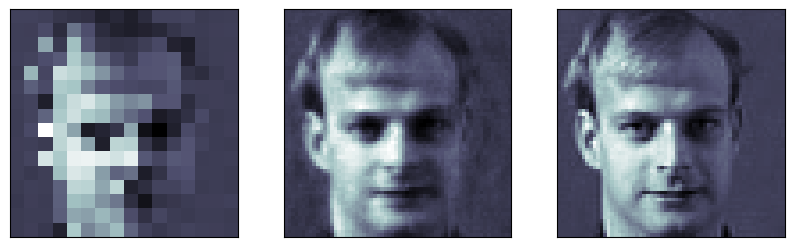

2 :	input		      prediction		  target


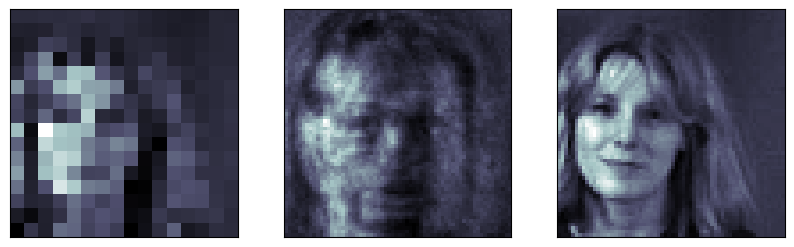

3 :	input		      prediction		  target


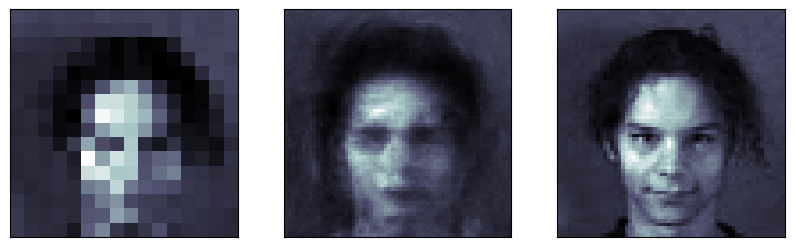

4 :	input		      prediction		  target


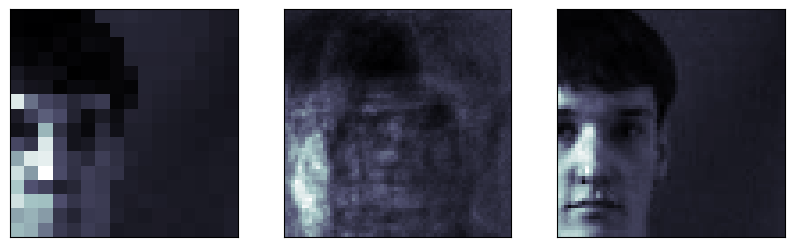

5 :	input		      prediction		  target


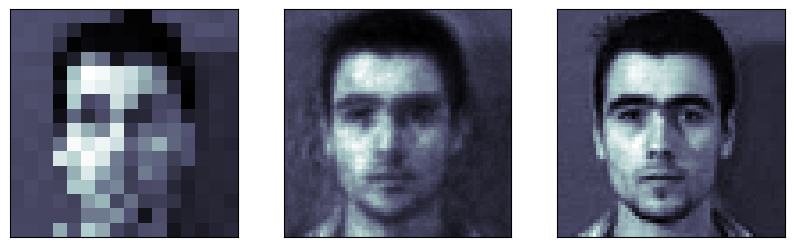

6 :	input		      prediction		  target


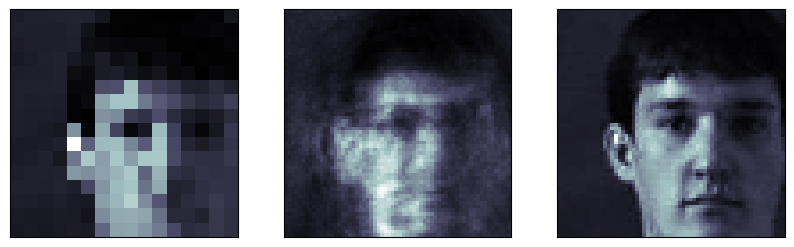

7 :	input		      prediction		  target


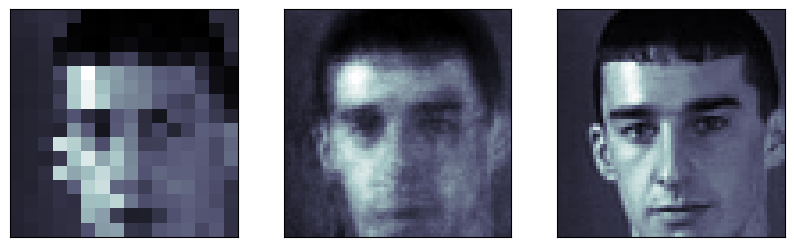

8 :	input		      prediction		  target


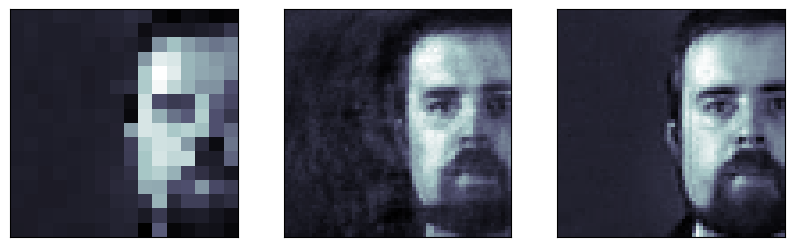

9 :	input		      prediction		  target


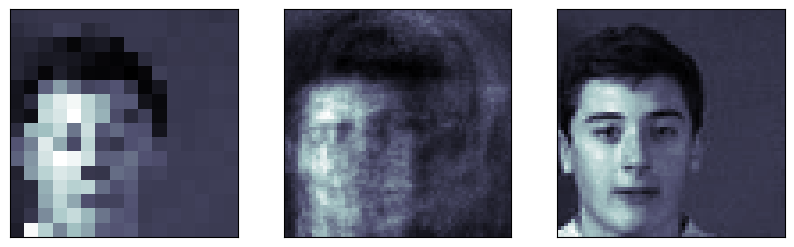

10 :	input		      prediction		  target


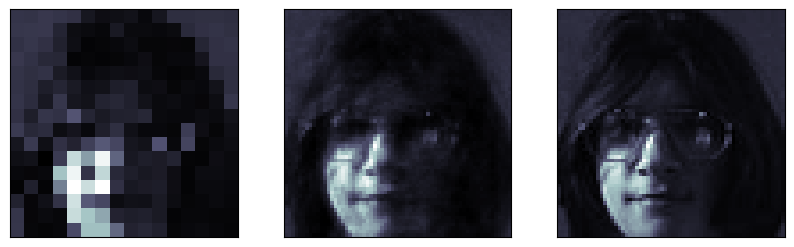

11 :	input		      prediction		  target


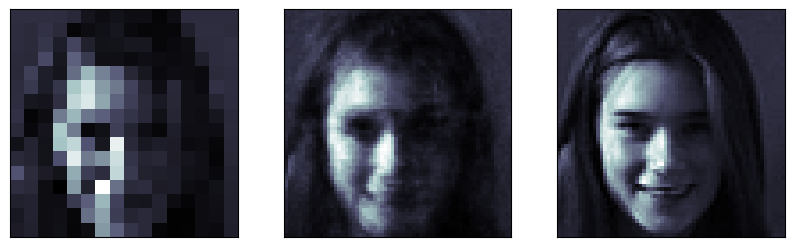

12 :	input		      prediction		  target


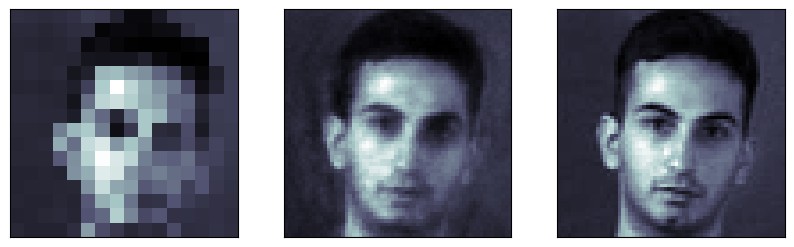

In [ ]:
outim = model_flat.predict(X_te_flat)
# pick a few random test images
for i in range(0, len(X_te), 1):
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout_flat(i, outim, X_te_flat)
  pl.show()

# 4 build a convolutional autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be

512 (input size) -> 256 -> 128 (-> 56) -> 128 -> 256 -> 1204 (output size)

In [ ]:
# this model is 16x16 (input size) -> 64x64 (output size)

model = Sequential()

input_img = Input(shape=X_tr[0].shape)

x = Conv2D(512, (3, 3), activation='relu', padding="same")(input_img)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
  #x = layers.Lambda(lambda x: K.mean(x, axis=1))(x1)
  #x = layers.MaxPooling2D((2, 2))(x)
  #x2 = layers.BatchNormalization()(x1)
  #x5 = layers.BatchNormalization()(x4)
encoded = MaxPooling2D((2, 2))(x)


x = Conv2D(128, (3, 3), activation='relu', padding="same")(encoded)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
#x = layers.Conv2D(128, (3, 3), activation='tanh', padding="same")(x)
x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding="same")(x)

model = Model(input_img, decoded)

model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [ ]:
print(model.summary())

Model: "functional_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 16, 16, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 512)         │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 64, 64, 1)           │           2,305 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,957,953 (11.28 MB)

 Trainable params: 2,957,953 (11.28 MB)

 Non-trainable params: 0 (0.00 B)

None


## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [ ]:
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=1e-6)

In [ ]:
# you can skip this and load the saved model
history = model.fit(X_tr, y_tr, epochs=100000,
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])


Epoch 1/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - acc: 1.9728e-05 - loss: 0.0411 - mae: 0.1566 - val_acc: 6.1035e-05 - val_loss: 0.0102 - val_mae: 0.0721
Epoch 2/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - acc: 1.3121e-05 - loss: 0.0102 - mae: 0.0725 - val_acc: 6.1035e-05 - val_loss: 0.0071 - val_mae: 0.0567
Epoch 3/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - acc: 1.3524e-05 - loss: 0.0077 - mae: 0.0595 - val_acc: 6.1035e-05 - val_loss: 0.0060 - val_mae: 0.0501
Epoch 4/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 1.1538e-05 - loss: 0.0068 - mae: 0.0552 - val_acc: 6.1035e-05 - val_loss: 0.0057 - val_mae: 0.0480
Epoch 5/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - acc: 1.9331e-05 - loss: 0.0061 - mae: 0.0515 - val_acc: 6.1035e-05 - val_loss: 0.0053 - val_mae: 0.0460
Epoch 6/100000
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 1.4013e-05 - loss: 0.0056 - mae: 0.0493 - val_acc: 6.1035e-05 - val_loss: 0.0058 - val_mae: 0.0513
Epoch 7/100000
71/71 ━━━━━━━━━━━

In [ ]:
#model.save("imgreconstruct_100000PUS_factor4.h5")

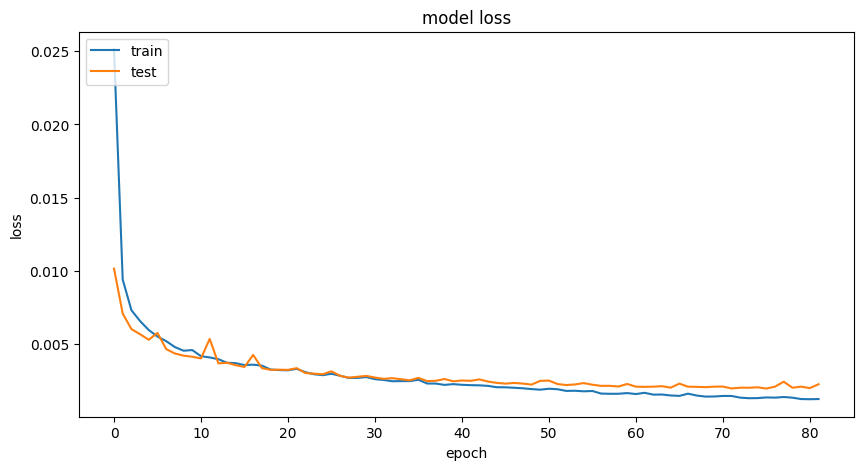

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

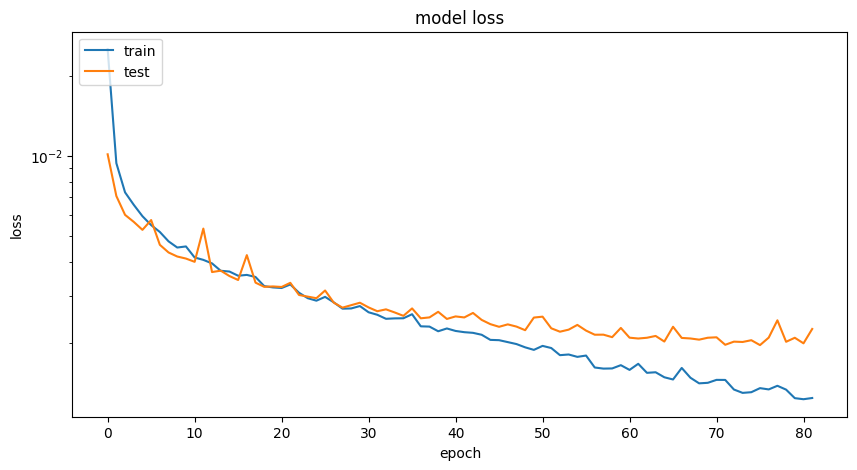

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.yscale('log')
plt.show()

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
#model.load_weights("data/conv_imgreconstruct_10000.h5")

## predict

In [ ]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131)
  ax.imshow(X_te[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  ax.imshow(outim[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133)
  ax.imshow(y_te[i], cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


In [ ]:
outim = model.predict(X_te)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


2 :	input		      prediction		  target


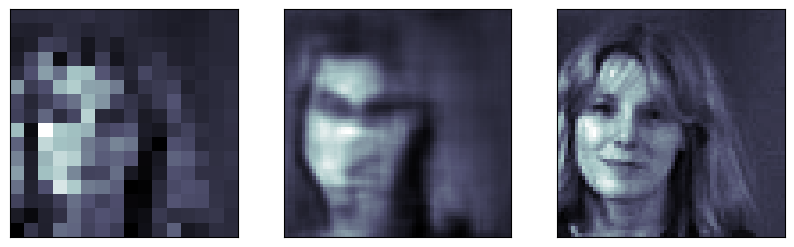

3 :	input		      prediction		  target


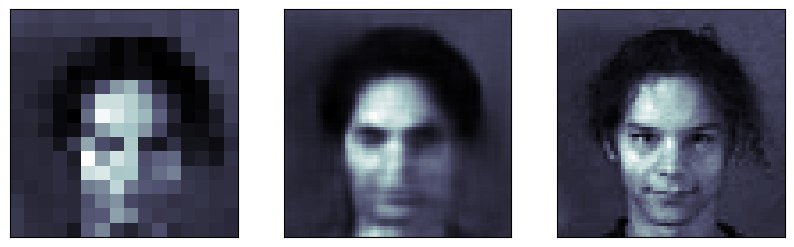

4 :	input		      prediction		  target


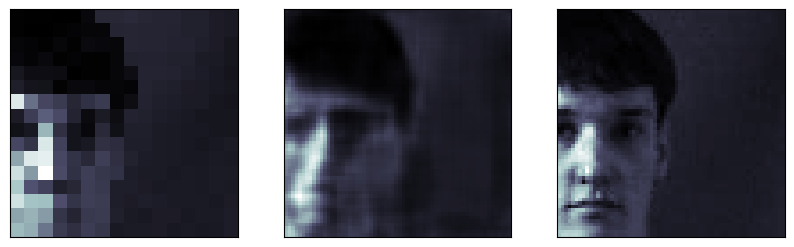

5 :	input		      prediction		  target


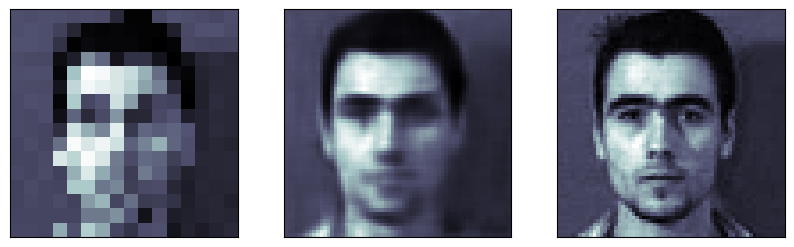

6 :	input		      prediction		  target


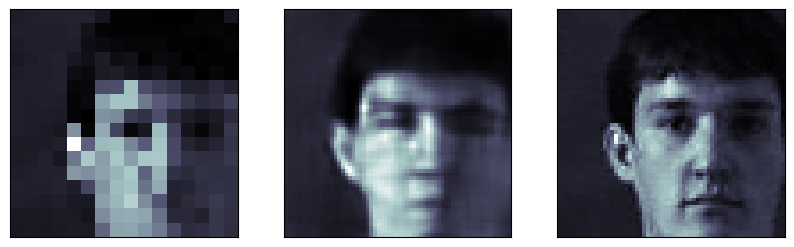

7 :	input		      prediction		  target


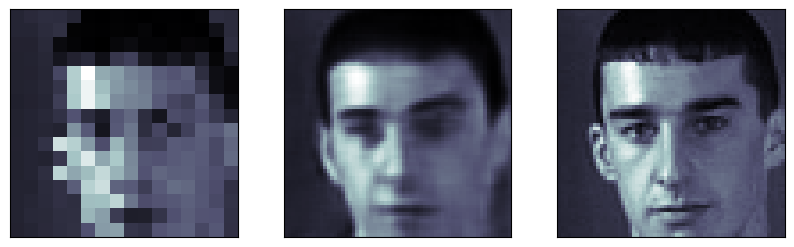

8 :	input		      prediction		  target


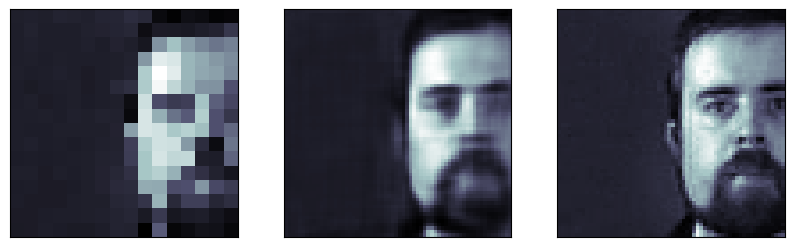

9 :	input		      prediction		  target


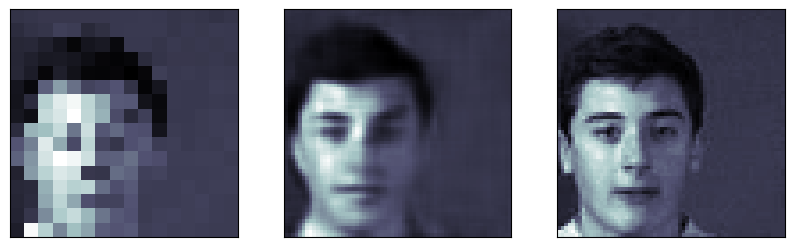

10 :	input		      prediction		  target


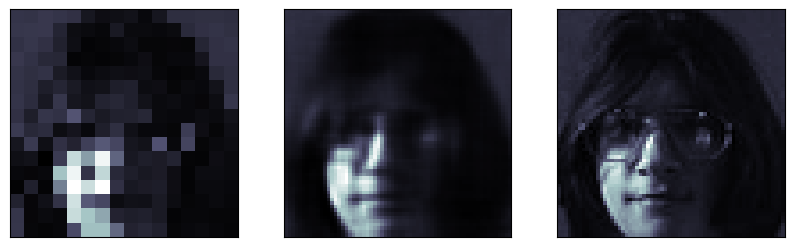

11 :	input		      prediction		  target


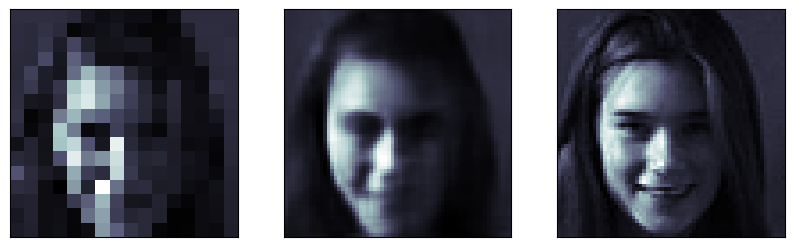

12 :	input		      prediction		  target


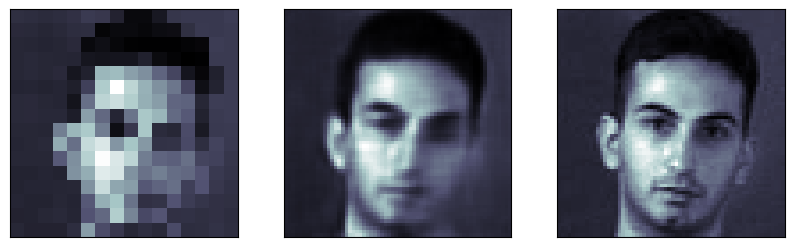

In [ ]:
np.random.seed(302)
# pick a few random test images
for i in range(1, len(X_te)):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(i, outim, X_te)
  pl.show()

What do you think? some are pretty good right?! e.g. 1, 4, 6, 7, 8

Some are really bad. 9... why?

#5 IS THIS NN TRANSFERABLE? test the model on your own image
 depending on the initial size you will have to downsample the image, and extract a single color layer

In [ ]:
from google.colab import files
from io import BytesIO
from PIL import Image
uploaded = files.upload()


Saving headshot_TED.png to headshot_TED.png


In [ ]:
file_contents = uploaded[list(uploaded.keys())[0]]


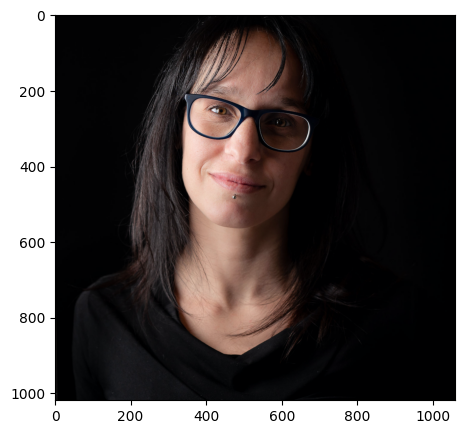

In [ ]:
imme = Image.open(BytesIO(file_contents))
plt.imshow(imme)

(320, 320, 1)

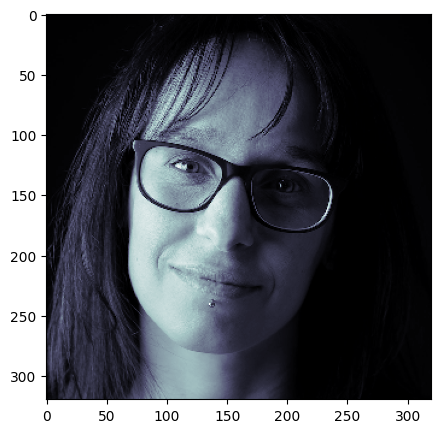

In [ ]:
np_im = numpy.array(imme)[:640:2,200:840:2].astype(float) / 255
np_im = np_im.mean(axis=2, keepdims=True)
pl.figure()
pl.imshow(np_im, cmap="bone");
np_im.shape

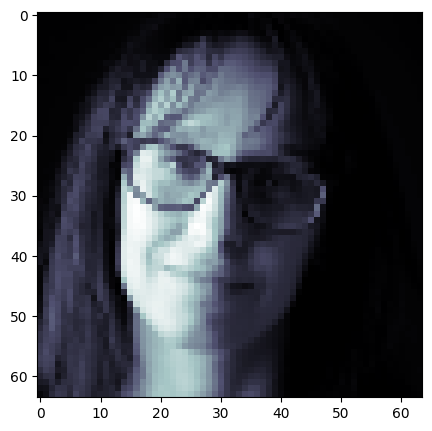

In [ ]:
# prompt: resample array to decrease size to 64x64 with average filter
from skimage.measure import block_reduce

# Assuming np_im is your original array
np_im_resized = block_reduce(np_im, 5, np.mean)

plt.imshow(np_im_resized, cmap="bone")


low resolution version
subsampling by 15

In [ ]:
np_im_me = np_im_resized[::4, ::4, :]#[::15,::15,1]
np_im_me.shape

(16, 16, 1)

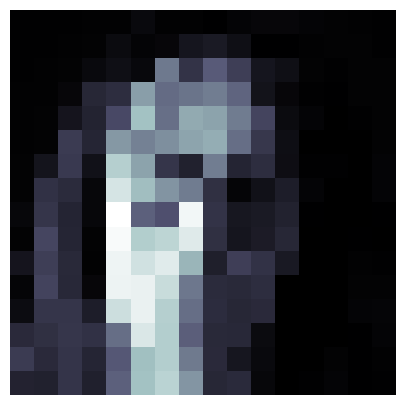

In [ ]:
pl.imshow(np_im_me, cmap="bone")
pl.axis('off');

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


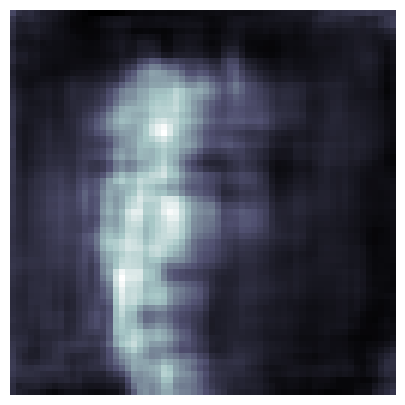

In [ ]:
pl.imshow(model.predict(np.array([np_im_me]))[0],
          cmap="bone")
pl.axis('off');

# ... not good at all :-( why??